# # 📘 CarlaBEV — DRL Analysis Notebook
#
# This notebook loads training & evaluation results from the folder:
# `runs_final/<exp_name>/`
#
# and generates plots grouped by:
# - Traffic (on/off)
# - Input type (RGB / Masks)
# - Reward (Shaping / CaRL)
# - Curriculum mode (off / on / variants)
#
# Requirements:
#   pandas, numpy, matplotlib, seaborn, tensorboardX (optional)

In [1]:
# ============================
# 🔧 Imports & Setup
# ============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns


plt.style.use("seaborn-v0_8")
sns.set_theme()

# If plots look too crowded, increase default size:
plt.rcParams["figure.figsize"] = (10,5)

from analysis_utils import (
    plot_grouped_metric,
    heatmap_metric,
    plot_training_curve,
    scatter_success_collision,
    boxplot_metric,
    compare_rewards,
    ranking_table,
)

# Your helper functions for loading results:
from load_results import load_all_results, load_only_eval_results

# # 📥 Load Data
# - `df_train` = Training curves (many rows)
# - `df_eval` = Final evaluation metrics (1 row per experiment)

In [3]:
df_eval = load_only_eval_results()


📁 Experiment: exp-10_cnn-ppo_traffic-on_input-rgb_rwd-shaping_curr-on  ({'experiment': 'exp-10_cnn-ppo_traffic-on_input-rgb_rwd-shaping_curr-on', 'exp_id': 10, 'algo': 'cnn-ppo', 'traffic': 'on', 'input': 'rgb', 'reward': 'shaping', 'curriculum': 'on'})
  ✓ Eval: success=0.545, collision=0.300, return=46.63

📁 Experiment: exp-11_cnn-ppo_traffic-on_input-rgb_rwd-carl_curr-off  ({'experiment': 'exp-11_cnn-ppo_traffic-on_input-rgb_rwd-carl_curr-off', 'exp_id': 11, 'algo': 'cnn-ppo', 'traffic': 'on', 'input': 'rgb', 'reward': 'carl', 'curriculum': 'off'})
  ✓ Eval: success=0.484, collision=0.247, return=32.80

📁 Experiment: exp-12_cnn-ppo_traffic-on_input-rgb_rwd-carl_curr-on  ({'experiment': 'exp-12_cnn-ppo_traffic-on_input-rgb_rwd-carl_curr-on', 'exp_id': 12, 'algo': 'cnn-ppo', 'traffic': 'on', 'input': 'rgb', 'reward': 'carl', 'curriculum': 'on'})
  ✓ Eval: success=0.542, collision=0.247, return=34.73

📁 Experiment: exp-13_cnn-ppo_traffic-on_input-masks_rwd-shaping_curr-off  ({'experim

In [4]:
#print("Training DF shape:", df_train.shape)
print("Eval DF shape:", df_eval.shape)

df_eval.head()

Eval DF shape: (24, 13)


,experiment,exp_id,algo,traffic,input,reward,curriculum,mean_return,std_return,mean_length,success_rate,collision_rate,unfinished_rate
0,exp-10_cnn-ppo_traffic-on_input-rgb_rwd-shapin...,10,cnn-ppo,on,rgb,shaping,on,46.625072,37.351429,493.751007,0.545,0.300,0.155
1,exp-11_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,11,cnn-ppo,on,rgb,carl,off,32.803997,17.773703,496.252991,0.484,0.247,0.269
2,exp-12_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,12,cnn-ppo,on,rgb,carl,on,34.732716,17.575584,500.442993,0.542,0.247,0.211
3,exp-13_cnn-ppo_traffic-on_input-masks_rwd-shap...,13,cnn-ppo,on,masks,shaping,off,48.226719,37.311127,484.725006,0.561,0.341,0.098
4,exp-14_cnn-ppo_traffic-on_input-masks_rwd-shap...,14,cnn-ppo,on,masks,shaping,on,48.040798,37.884624,486.514008,0.561,0.336,0.103


In [5]:
# --------------------------
# Metadata lookup
# --------------------------
EXPERIMENT_TABLE = {
    1: ("off", "rgb", "shaping", "off"),
    2: ("off", "rgb", "shaping", "on"),
    3: ("off", "rgb", "carl", "off"),
    4: ("off", "rgb", "carl", "on"),
    5: ("off", "masks", "shaping", "off"),
    6: ("off", "masks", "shaping", "on"),
    7: ("off", "masks", "carl", "off"),
    8: ("off", "masks", "carl", "on"),
    9: ("on", "rgb", "shaping", "off"),
    10: ("on", "rgb", "shaping", "on"),
    11: ("on", "rgb", "carl", "off"),
    12: ("on", "rgb", "carl", "on"),
    13: ("on", "masks", "shaping", "off"),
    14: ("on", "masks", "shaping", "on"),
    15: ("on", "masks", "carl", "off"),
    16: ("on", "masks", "carl", "on"),
    17: ("on", "rgb", "carl", "vehicles_only"),
    18: ("on", "rgb", "carl", "route_only"),
    19: ("on", "rgb", "carl", "both"),
    20: ("on", "masks", "carl", "vehicles_only"),
    21: ("on", "masks", "carl", "route_only"),
    22: ("on", "masks", "carl", "both"),
    23: ("off", "rgb", "carl", "route_only"),
    24: ("off", "masks", "carl", "route_only"),
}

In [6]:
# ---- same style dictionaries as before ----
COLOR_MAP = {
    "shaping": "#4C72B0",   # blue
    "carl": "#DD8452",      # orange
}

HATCH_MAP = {
    "rgb": "//",
    "masks": ".."
}

CURR_LINEWIDTH = {
    "off": 1.5, 
    "on": 3.5,
    "vehicles_only": 3.5,
    "route_only": 3.5,
    "both": 3.5,
}

## PLOT FUNCTIONS

In [7]:
# ============================================================
# Global Matplotlib Style for ALL Plots
# ============================================================

plt.style.use("default")  # reset defaults

# ---- Base font sizes ----
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 18

# ---- Figure size ----
plt.rcParams["figure.figsize"] = (10, 6)

# ---- Line widths ----
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["axes.linewidth"] = 1.2

# ---- Grid ----
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["grid.alpha"] = 0.3

# ---- Legend ----
plt.rcParams["legend.framealpha"] = 1.0
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True

# ---- Colors: Colorblind-safe palette ----
cb_palette = [
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#009E73",  # bluish green
    "#CC79A7",  # reddish purple
    "#F0E442",  # yellow
    "#56B4E9",  # sky blue
    "#E69F00",  # orange
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cb_palette)

# ---- Tick parameters ----
plt.rcParams["xtick.major.size"] = 6
plt.rcParams["xtick.major.width"] = 1.2
plt.rcParams["ytick.major.size"] = 6
plt.rcParams["ytick.major.width"] = 1.2

# ---- Title position ----
plt.rcParams["axes.titlepad"] = 12

# ---- Savefig quality ----
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

print("🔧 Global Matplotlib style loaded!")


🔧 Global Matplotlib style loaded!


In [8]:

def plot_success_barh(df_eval, selected_ids):
    """
    Horizontal bar chart for success rate.
    Color → reward type
    Hatch → input type
    Border thickness → curriculum ON/OFF
    """

    rows = []

    # Filter rows
    for _, row in df_eval.iterrows():
        try:
            exp_id = int(row["experiment"].split("-")[1].split("_")[0])
        except:
            continue
        if exp_id in selected_ids:
            traffic, inp, reward, curr = EXPERIMENT_TABLE[exp_id]
            rows.append({
                "id": exp_id,
                "success_rate": row["success_rate"],
                "reward": reward,
                "input": inp,
                "curriculum": curr,
            })

    if not rows:
        print("⚠️ No matching experiments.")
        return

    df = pd.DataFrame(rows).sort_values("success_rate")

    # --- Plot ---
    plt.figure(figsize=(14, 8))
    plt.style.use("seaborn-v0_8-whitegrid")

    y_positions = range(len(df))

    for y, (_, r) in zip(y_positions, df.iterrows()):
        plt.barh(
            y=y,
            width=r["success_rate"],
            color=COLOR_MAP[r["reward"]],
            hatch=HATCH_MAP[r["input"]],
            edgecolor="black",
            linewidth=CURR_LINEWIDTH[r["curriculum"]],
            alpha=0.9
        )

        # annotate
        plt.text(
            r["success_rate"] + 0.015,
            y,
            f"{r['success_rate']:.2f}",
            va="center",
            fontsize=16
        )

    plt.xlabel("Success Rate", fontsize=20)
    plt.ylabel("Experiment ID", fontsize=20)
    plt.yticks(y_positions, df["id"].astype(str), fontsize=16)
    plt.title("Success Rate Comparison Across Selected Experiments", fontsize=24, weight="bold")
    plt.xlim(0, 1.1)

    # ---------------------
    # Legend
    # ---------------------

    # Reward type legend
    reward_handles = [
        Patch(facecolor=COLOR_MAP[k], edgecolor="black",
              label=f"Reward: {k.title()}", linewidth=1.5)
        for k in COLOR_MAP
    ]

    # Input type legend
    input_handles = [
        Patch(facecolor="white", edgecolor="black", hatch=HATCH_MAP[k],
              label=f"Input: {k.upper()}", linewidth=1.5)
        for k in HATCH_MAP
    ]

    # Curriculum legend
    curr_handles = [
        Patch(facecolor="white", edgecolor="black",
              label="Curriculum OFF", linewidth=CURR_LINEWIDTH["off"]),
        Patch(facecolor="white", edgecolor="black",
              label="Curriculum ON", linewidth=CURR_LINEWIDTH["on"]),
    ]

    # Combine
    handles = reward_handles + input_handles + curr_handles

    # Legend with white box
    plt.legend(
        handles=handles,
        fontsize=14,
        loc="lower right",
        framealpha=1.0,
        facecolor="white",
        edgecolor="black",
        frameon=True
    )

    plt.tight_layout()
    plt.show()

In [9]:
def plot_eval_mean_candle(
    df_eval,
    exp_ids,
    interval="std",   # "std" or "ci95" (mean ± 1.96*std)
    title="Eval Performance: Mean Return With Interval"
):
    """
    Floating candle plot for eval results.
    
    interval:
        "std"  → mean ± std
        "ci95" → mean ± 1.96 * std
    """

    df = df_eval[df_eval["exp_id"].isin(exp_ids)].copy()
    df = df.sort_values("exp_id")

    if df.empty:
        print("⚠️ No matching experiments for:", exp_ids)
        return

    means = df["mean_return"].values
    stds  = df["std_return"].values
    x     = np.arange(len(df))

    # choose interval width
    if interval == "ci95":
        delta = 1.96 * stds
        label_int = "95% CI"
    else:
        delta = stds
        label_int = "Std Dev"

    lower = means - delta
    upper = means + delta

    plt.figure(figsize=(10, 6))

    # --- floating candles: vertical lines ---
    plt.vlines(x, lower, upper, color="tab:blue", linewidth=3, label=label_int)

    # --- mean markers ---
    plt.scatter(x, means, color="black", s=80, zorder=5, label="Mean return")

    # --- style ---
    plt.xticks(x, df["exp_id"].astype(int), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Experiment ID", fontsize=14)
    plt.ylabel("Mean return", fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Also display table for reference
    display(df[["exp_id", "mean_return", "std_return", 
                "success_rate", "collision_rate", "unfinished_rate",
                "traffic", "input", "reward", "curriculum"]])

In [10]:
def plot_success_vs_collision(df_eval, selected_ids):
    """
    Scatter plot success_rate vs collision_rate using:
    - color = reward type
    - hatch = input type
    - border linewidth = curriculum ON/OFF
    """

    rows = []

    # filter experiments based on list of IDs
    for _, row in df_eval.iterrows():
        try:
            exp_id = int(row["experiment"].split("-")[1].split("_")[0])
        except:
            continue
        if exp_id in selected_ids:
            traffic, inp, reward, curr = EXPERIMENT_TABLE[exp_id]
            rows.append({
                "id": exp_id,
                "success_rate": row["success_rate"],
                "collision_rate": row["collision_rate"],
                "reward": reward,
                "input": inp,
                "curriculum": curr,
            })

    if not rows:
        print("⚠️ No matching experiments.")
        return

    df = pd.DataFrame(rows)

    # ---------- Plot ----------
    plt.figure(figsize=(14, 10))
    plt.style.use("seaborn-v0_8-whitegrid")

    for _, r in df.iterrows():
        plt.scatter(
            r["collision_rate"],
            r["success_rate"],
            s=220,                           # marker size
            c=COLOR_MAP[r["reward"]],
            edgecolors="black",
            linewidths=CURR_LINEWIDTH[r["curriculum"]],
            alpha=0.9,
            marker="o"                       # simple, clean marker
        )

        # hatch overlay → we draw a second "outline-only" marker to create hatching
        plt.scatter(
            r["collision_rate"],
            r["success_rate"],
            s=220,
            facecolors="none",
            edgecolors="black",
            linewidths=1.5,
            marker="o",
            hatch=HATCH_MAP[r["input"]],
            alpha=0.9
        )

        # Annotate experiment ID
        plt.text(
            r["collision_rate"] + 0.015,
            r["success_rate"] - 0.007,
            str(r["id"]),
            fontsize=16,
            weight="bold"
        )

    plt.xlabel("Collision Rate", fontsize=20)
    plt.ylabel("Success Rate", fontsize=20)
    plt.title("Success vs Collision Rate Across Selected Experiments",
              fontsize=24, weight="bold")

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.xlim(-0.02, 1.05)
    plt.ylim(-0.02, 1.05)

    # ---------- Legend ----------
    reward_handles = [
        Patch(facecolor=COLOR_MAP[k], edgecolor="black",
              label=f"Reward: {k.title()}", linewidth=1.5)
        for k in COLOR_MAP
    ]

    input_handles = [
        Patch(facecolor="white", edgecolor="black", hatch=HATCH_MAP[k],
              label=f"Input: {k.upper()}", linewidth=1.5)
        for k in HATCH_MAP
    ]

    curr_handles = [
        Patch(facecolor="white", edgecolor="black",
              label="Curriculum OFF", linewidth=CURR_LINEWIDTH["off"]),
        Patch(facecolor="white", edgecolor="black",
              label="Curriculum ON", linewidth=CURR_LINEWIDTH["on"]),
    ]

    handles = reward_handles + input_handles + curr_handles

    plt.legend(
        handles=handles,
        fontsize=14,
        loc="lower right",
        framealpha=1.0,
        facecolor="white",
        edgecolor="black",
        frameon=True
    )

    plt.tight_layout()
    plt.show()

## RESULTS

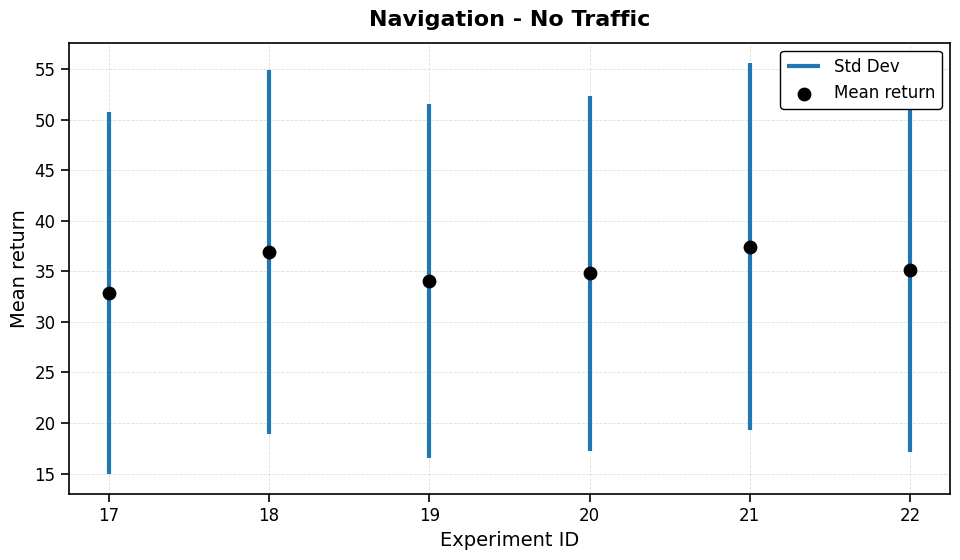

,exp_id,mean_return,std_return,success_rate,collision_rate,unfinished_rate,traffic,input,reward,curriculum
7,17,32.896103,17.918116,0.499,0.254,0.247,on,rgb,carl,vehicles
8,18,36.909447,18.027594,0.574,0.241,0.185,on,rgb,carl,route
9,19,34.073929,17.551168,0.498,0.259,0.243,on,rgb,carl,both
11,20,34.814564,17.545433,0.547,0.278,0.175,on,masks,carl,vehicles
12,21,37.467678,18.152449,0.613,0.258,0.129,on,masks,carl,route
13,22,35.146748,18.044586,0.543,0.296,0.161,on,masks,carl,both


In [11]:
traffic_off = [17, 18, 19, 20, 21, 22]
plot_eval_mean_candle(df_eval, traffic_off, title="Navigation - No Traffic")

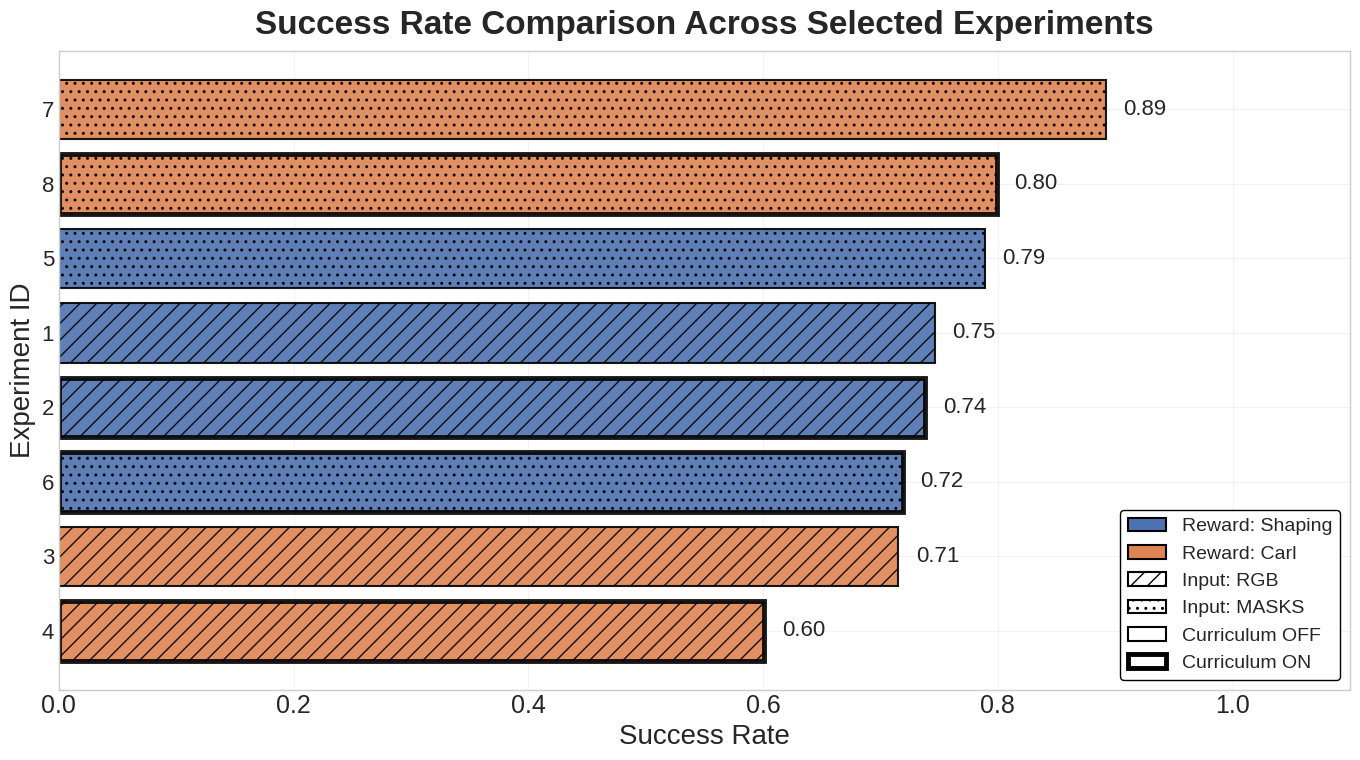

In [12]:
plot_success_barh(df_eval, selected_ids=[1,2,3,4,5,6,7,8])

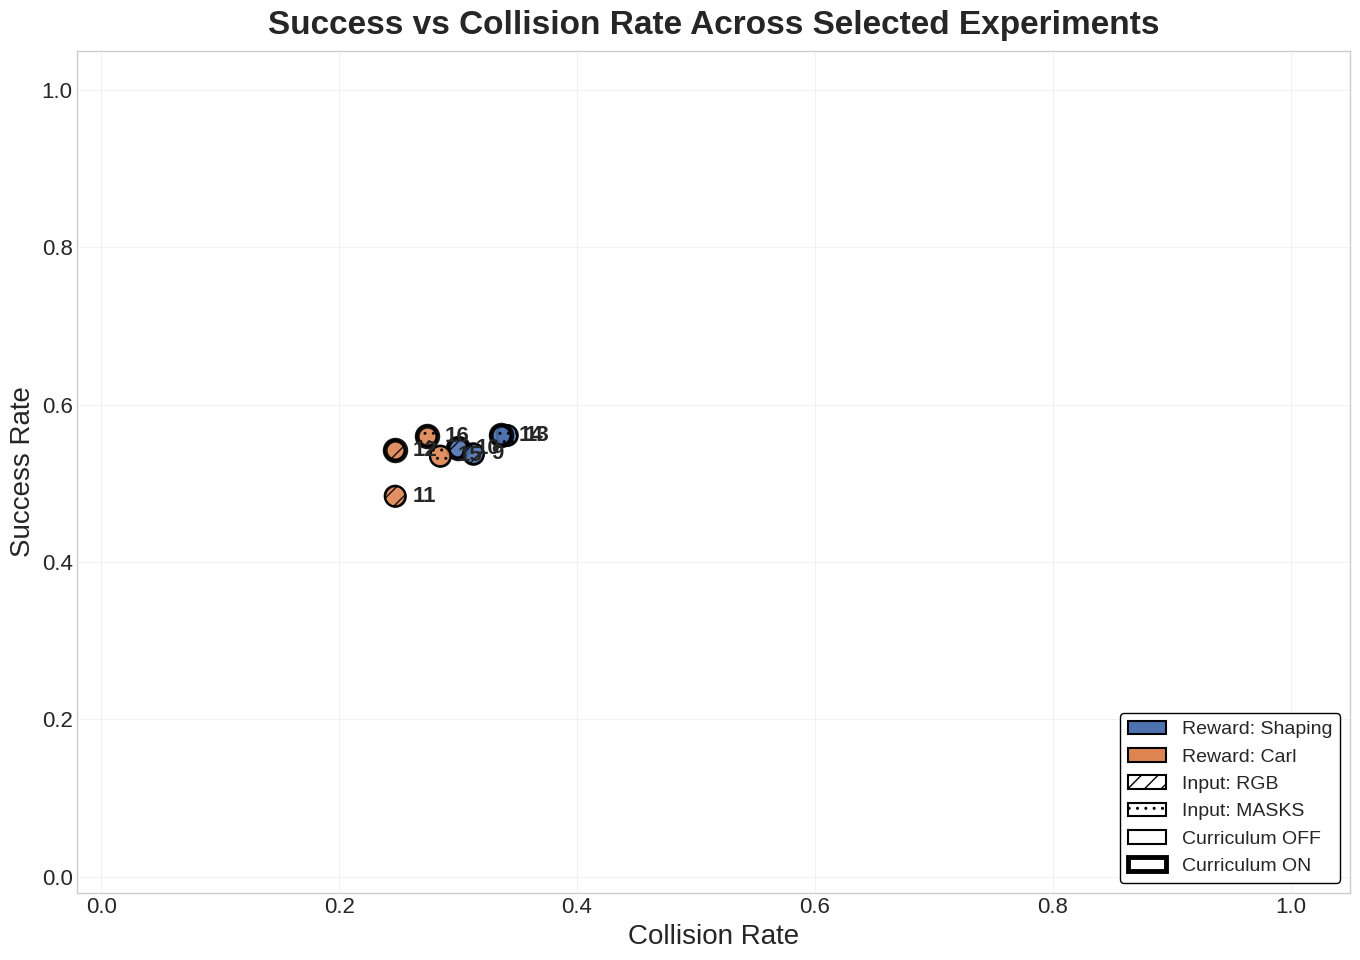

In [25]:
# --------------------------------------
# 1) Select which experiments to plot
# --------------------------------------
selected_ids = [9, 10, 11, 12, 13, 14, 15, 16]   # 👈 EDIT THIS LIST
plot_success_vs_collision(df_eval, selected_ids)

In [12]:
df_eval

,experiment,exp_id,algo,traffic,input,reward,curriculum,mean_return,std_return,mean_length,success_rate,collision_rate,unfinished_rate
0,exp-10_cnn-ppo_traffic-on_input-rgb_rwd-shapin...,10,cnn-ppo,on,rgb,shaping,on,40.476604,37.485481,487.800000,0.466667,0.266667,0.266667
1,exp-11_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,11,cnn-ppo,on,rgb,carl,off,34.426092,18.406413,504.000000,0.466667,0.200000,0.333333
2,exp-12_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,12,cnn-ppo,on,rgb,carl,on,29.095601,19.917148,496.666667,0.433333,0.266667,0.300000
3,exp-13_cnn-ppo_traffic-on_input-masks_rwd-shap...,13,cnn-ppo,on,masks,shaping,off,56.129932,37.911821,553.733333,0.633333,0.266667,0.100000
4,exp-14_cnn-ppo_traffic-on_input-masks_rwd-shap...,14,cnn-ppo,on,masks,shaping,on,59.087656,30.050238,520.666667,0.700000,0.266667,0.033333
5,exp-15_cnn-ppo_traffic-on_input-masks_rwd-carl...,15,cnn-ppo,on,masks,carl,off,38.752573,15.966408,517.800000,0.666667,0.166667,0.166667
6,exp-16_cnn-ppo_traffic-on_input-masks_rwd-carl...,16,cnn-ppo,on,masks,carl,on,37.248109,13.819323,544.166667,0.533333,0.333333,0.133333
7,exp-17_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,17,cnn-ppo,on,rgb,carl,vehicles,34.335401,17.383401,487.100000,0.500000,0.266667,0.233333
8,exp-18_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,18,cnn-ppo,on,rgb,carl,route,39.279495,17.824472,553.733333,0.633333,0.200000,0.166667
9,exp-19_cnn-ppo_traffic-on_input-rgb_rwd-carl_c...,19,cnn-ppo,on,rgb,carl,both,37.195414,15.250866,532.366667,0.533333,0.233333,0.233333


In [23]:
# ------------------------------------------------------------
# Helper: consistent pivot + annotation formatting
# ------------------------------------------------------------
def _pivot_mean(df, index, columns, metric):
    heat_df = df.pivot_table(
        index=index,
        columns=columns,
        values=metric,
        aggfunc="mean"
    )
    return heat_df


# ============================================================
# (1) Heatmap: Success Rate (Input × Reward) with facets = Traffic OFF/ON
#     -> This matches the first image.
# ============================================================
def plot_heatmap_input_reward_by_traffic(df_eval, metric="success_rate", cmap="rocket"):
    """
    Facets  -> traffic (off/on)
    Rows    -> input (rgb/masks)
    Columns -> reward (shaping/carl)
    """
    df = df_eval.copy()

    traffics = ["off", "on"]
    traffics_present = [t for t in traffics if t in df["traffic"].unique()]
    if not traffics_present:
        print("⚠️ No traffic values found in df_eval['traffic'].")
        return

    # fixed ordering (prevents random order changes)
    inputs = ["rgb", "masks"]
    rewards = ["shaping", "carl"]

    fig, axes = plt.subplots(
        1, len(traffics_present),
        figsize=(7.6 * len(traffics_present), 5.2),
        sharey=True
    )
    if len(traffics_present) == 1:
        axes = [axes]

    vmin, vmax = 0.0, 1.0

    for ax, traffic in zip(axes, traffics_present):
        sub = df[df["traffic"] == traffic]

        heat_df = _pivot_mean(sub, index="input", columns="reward", metric=metric)
        heat_df = heat_df.reindex(index=inputs, columns=rewards)

        sns.heatmap(
            heat_df,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            linewidths=1.5,
            linecolor="white",
            square=True,
            cbar=True if ax == axes[-1] else False,
            cbar_kws={"label": metric.replace("_", " ").title()},
            ax=ax,
            annot_kws={"fontsize": 13, "fontweight": "bold"},
        )

        ax.set_title(f"Traffic = {traffic.upper()}", fontsize=18, pad=12, fontweight="bold")
        ax.set_xlabel("Reward", fontsize=16)
        ax.set_ylabel("Input", fontsize=16)
        ax.tick_params(axis="both", labelsize=13)

    fig.suptitle(
        f"{metric.replace('_',' ').title()} (Input × Reward)",
        fontsize=22, fontweight="bold", y=1.02
    )
    #plt.tight_layout()
    plt.show()


# ============================================================
# (2) Heatmap: Success Rate vs Curriculum (Traffic=ON, Reward=CaRL)
#     Facets = curriculum modes (vehicles/route/both)
#     Columns = [off vs <curriculum mode>] (i.e., "Curr mode vs Curr off")
#     -> This matches the second image.
# ============================================================
def plot_heatmap_curriculum_vs_off_facets(
    df_eval,
    metric="success_rate",
    traffic_value="on",
    reward_value="carl",
    curriculum_modes=("vehicles", "route", "both"),
    cmap="rocket",
):
    """
    Facets  -> curriculum mode in {vehicles, route, both}
    Rows    -> input (rgb/masks)
    Cols    -> curriculum_mode = ["off", <mode>]
    Filters -> traffic == traffic_value AND reward == reward_value
    """
    df = df_eval.copy()

    # Filter to the slice shown in the figure
    df = df[(df["traffic"] == traffic_value) & (df["reward"] == reward_value)]
    if df.empty:
        print("⚠️ No rows after filtering traffic/reward. Check df_eval columns/values.")
        return

    inputs = ["masks", "rgb"]  # match the visual ordering you had
    cols = ["off", None]       # second will be replaced per facet

    modes_present = [m for m in curriculum_modes if m in df["curriculum"].unique()]
    if not modes_present:
        print("⚠️ None of the requested curriculum modes are present in df_eval['curriculum'].")
        return

    fig, axes = plt.subplots(
        1, len(modes_present),
        figsize=(6.2 * len(modes_present), 8.2),
        sharey=True
    )
    if len(modes_present) == 1:
        axes = [axes]

    vmin, vmax = 0.0, 1.0

    for ax, mode in zip(axes, modes_present):
        # Keep only "off" baseline and the facet mode
        sub = df[df["curriculum"].isin(["off", mode])].copy()
        sub["curriculum_col"] = sub["curriculum"].apply(lambda c: "off" if c == "off" else mode)

        heat_df = _pivot_mean(sub, index="input", columns="curriculum_col", metric=metric)
        heat_df = heat_df.reindex(index=inputs, columns=["off", mode])

        # One colorbar for the last subplot (as in your screenshot)
        sns.heatmap(
            heat_df,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            linewidths=1.5,
            linecolor="black",
            square=True,
            cbar=True if ax == axes[-1] else False,
            cbar_kws={"label": "Success Rate"},
            ax=ax,
            annot_kws={"fontsize": 13, "fontweight": "bold"},
        )

        ax.set_title(f"Curriculum = {mode}", fontsize=16, pad=10, fontweight="bold")
        ax.set_xlabel("Curriculum Mode", fontsize=15)
        ax.set_ylabel("Input Type", fontsize=15)
        ax.tick_params(axis="both", labelsize=12)

    fig.suptitle(
        f"{metric.replace('_',' ').title()} vs Curriculum (Traffic = {traffic_value.upper()}, Reward = {reward_value.upper()})",
        fontsize=20, fontweight="bold", y=1.02
    )
    #plt.tight_layout()
    plt.show()


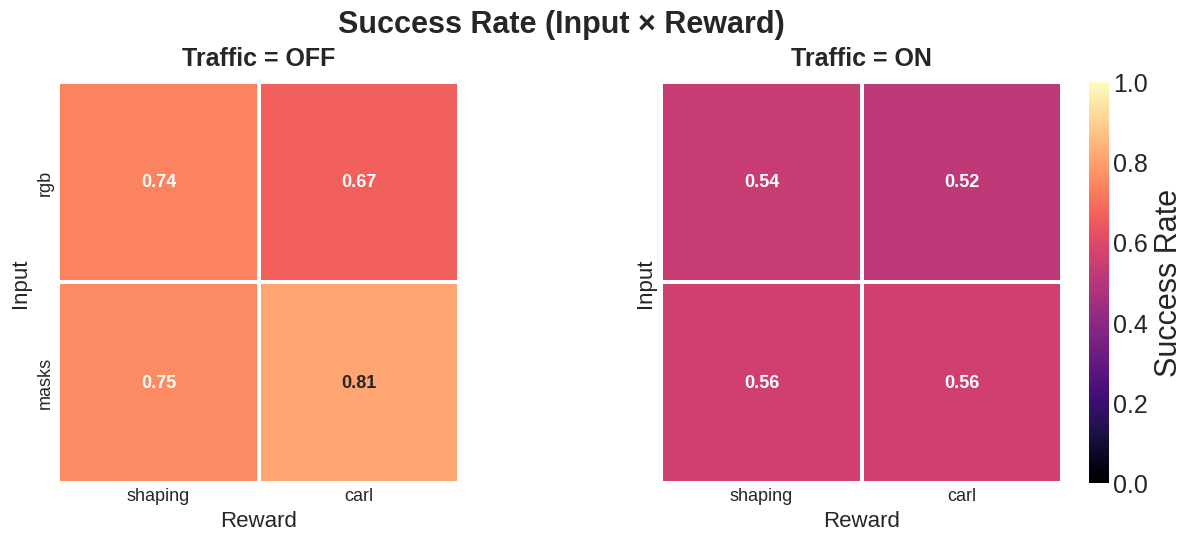

In [21]:
plot_heatmap_input_reward_by_traffic(df_eval, metric="success_rate", cmap="magma")

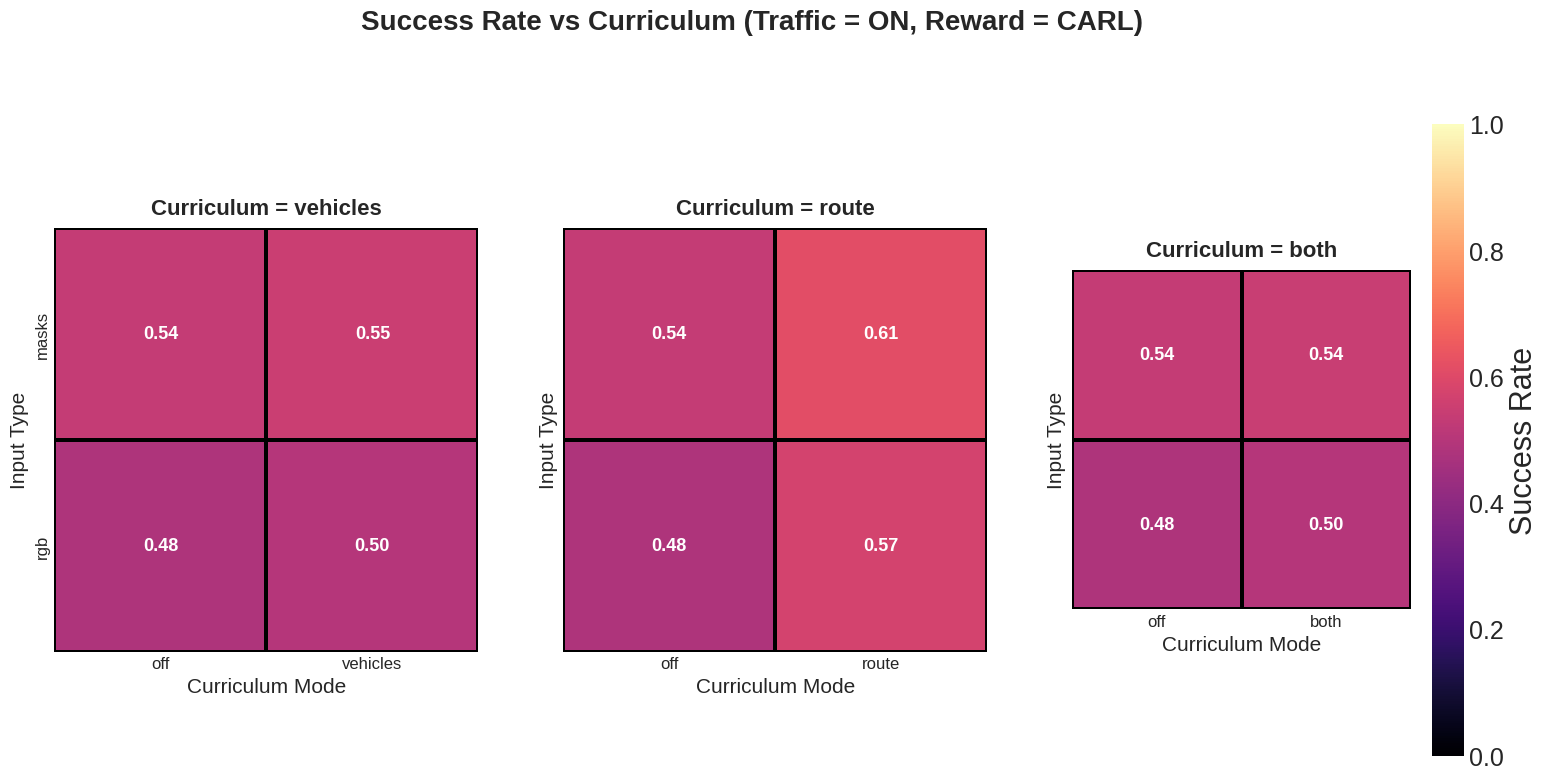

In [24]:
plot_heatmap_curriculum_vs_off_facets(df_eval, metric="success_rate", cmap="magma")